In [1]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_test_1 = pd.read_csv('data/X_test_1.csv')
y_test_1 = pd.read_csv('data/y_test_1.csv', names=['observation_id', 'true_class'],skiprows=1)
train_model = pd.read_csv('data/train_model.csv')

print("X_test_1 {}".format(X_test_1.shape))
print("y_test_1 {}".format(y_test_1.shape))
print("train_model {}".format(train_model.shape))

X_test_1 (4000, 13)
y_test_1 (4000, 2)
train_model (300447, 22)


In [28]:
X_test_1 .info()
y_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   observation_id                4000 non-null   object 
 1   Type                          4000 non-null   object 
 2   Date                          4000 non-null   object 
 3   Part of a policing operation  2203 non-null   object 
 4   Latitude                      1474 non-null   float64
 5   Longitude                     1474 non-null   float64
 6   Gender                        4000 non-null   object 
 7   Age range                     4000 non-null   object 
 8   Self-defined ethnicity        4000 non-null   object 
 9   Officer-defined ethnicity     4000 non-null   object 
 10  Legislation                   3999 non-null   object 
 11  Object of search              4000 non-null   object 
 12  station                       4000 non-null   object 
dtypes: 

In [59]:
X_test_1.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,station
0,3d931c84-94d3-4a14-869c-b10fef26e9ad,Person search,2020-01-01T00:56:00+00:00,False,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire
1,cf46ed6e-e6bb-4bc9-959d-ef2e5a8162a0,Person search,2020-01-01T01:45:00+00:00,False,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,nottinghamshire
2,3601e51b-f40a-4466-b884-d9284497462c,Person search,2020-01-01T02:53:14+00:00,NaN,NaN,NaN,Male,18-24,Other ethnic group - Any other ethnic group,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,city-of-london
3,95dae6a9-6775-4862-815f-61cf1b586384,Person search,2020-01-01T04:43:00+00:00,True,NaN,NaN,Female,18-24,Other ethnic group - Not stated,Mixed,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire
4,467c4766-3a3f-489d-bf09-5a698748499e,Person search,2020-01-01T05:08:30+00:00,NaN,51.512598,-0.084967,Male,10-17,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,city-of-london


In [60]:
y_test_1.head()

,observation_id,true_class
0,3d931c84-94d3-4a14-869c-b10fef26e9ad,False
1,cf46ed6e-e6bb-4bc9-959d-ef2e5a8162a0,False
2,3601e51b-f40a-4466-b884-d9284497462c,False
3,95dae6a9-6775-4862-815f-61cf1b586384,False
4,467c4766-3a3f-489d-bf09-5a698748499e,False


In [14]:
# columns = ['observation_id', 'Type', 'Date', 'Part of a policing operation', 'Latitude', 'Longitude', 'Gender', 'Age range', 
#            'Officer-defined ethnicity','Legislation','Object of search','station']


In [10]:
# no duplicate observation_id
X_test_1['observation_id'].duplicated().value_counts()

False    4000
Name: observation_id, dtype: int64

In [11]:
# no duplicate lines
X_test_1.duplicated().value_counts()

False    4000
dtype: int64

In [61]:
X_test_1['Date']=pd.to_datetime(X_test_1['Date'], infer_datetime_format=True)

# auxiliar Date feature (for temporal analyzis)
X_test_1['referencia'] = X_test_1['Date'].dt.year*100 + X_test_1['Date'].dt.month

X_test_1['Age range'] = X_test_1['Age range'].str.replace('"', "")

X_test_1.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,station,referencia
0,3d931c84-94d3-4a14-869c-b10fef26e9ad,Person search,2020-01-01 00:56:00+00:00,False,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire,202001
1,cf46ed6e-e6bb-4bc9-959d-ef2e5a8162a0,Person search,2020-01-01 01:45:00+00:00,False,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,nottinghamshire,202001
2,3601e51b-f40a-4466-b884-d9284497462c,Person search,2020-01-01 02:53:14+00:00,NaN,NaN,NaN,Male,18-24,Other ethnic group - Any other ethnic group,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,city-of-london,202001
3,95dae6a9-6775-4862-815f-61cf1b586384,Person search,2020-01-01 04:43:00+00:00,True,NaN,NaN,Female,18-24,Other ethnic group - Not stated,Mixed,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire,202001
4,467c4766-3a3f-489d-bf09-5a698748499e,Person search,2020-01-01 05:08:30+00:00,NaN,51.512598,-0.084967,Male,10-17,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,city-of-london,202001


In [62]:
# train['Part of a policing operation'] = train['Part of a policing operation'].fillna(False)


In [63]:
print("X_test_1")
print(X_test_1['Type'].value_counts(dropna=False))
print(X_test_1['Type'].value_counts(dropna=False, normalize=True))

print("\nTrain_model")
print(train_model['Type'].value_counts(dropna=False))
print(train_model['Type'].value_counts(dropna=False, normalize=True))

X_test_1
Person search                2975
Person and Vehicle search    1025
Name: Type, dtype: int64
Person search                0.74375
Person and Vehicle search    0.25625
Name: Type, dtype: float64

Train_model
person search                228807
person and vehicle search     71526
vehicle search                  114
Name: Type, dtype: int64
person search                0.761555
person and vehicle search    0.238065
vehicle search               0.000379
Name: Type, dtype: float64


In [64]:
print(y_test_1['true_class'].value_counts(dropna=False))
y_test_1['true_class'].value_counts(dropna=False, normalize=True)


False    2887
True     1113
Name: true_class, dtype: int64


False    0.72175
True     0.27825
Name: true_class, dtype: float64

In [65]:
print(train_model['target'].value_counts(dropna=False))
train_model['target'].value_counts(dropna=False, normalize=True)

0    238242
1     62205
Name: target, dtype: int64


0    0.792958
1    0.207042
Name: target, dtype: float64

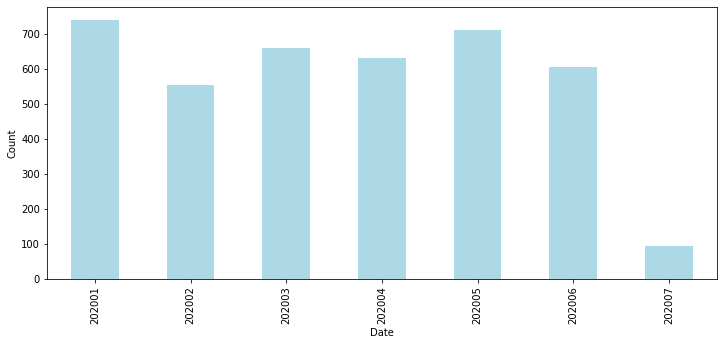

In [66]:
plt.figure(figsize=(12,5));
X_test_1['referencia'].value_counts(dropna=False).sort_index().plot(kind='bar',color='lightblue');
plt.xlabel('Date');
plt.ylabel('Count');

In [67]:
print("X_test_1")
print(X_test_1['Part of a policing operation'].value_counts(dropna=False))
print(X_test_1['Part of a policing operation'].value_counts(dropna=False, normalize=True))

print("\nTrain_model")
print(train_model['Part of a policing operation'].value_counts(dropna=False))
print(train_model['Part of a policing operation'].value_counts(dropna=False, normalize=True))

X_test_1
NaN      1797
False    1209
True      994
Name: Part of a policing operation, dtype: int64
NaN      0.44925
False    0.30225
True     0.24850
Name: Part of a policing operation, dtype: float64

Train_model
False    284173
True      16274
Name: Part of a policing operation, dtype: int64
False    0.945834
True     0.054166
Name: Part of a policing operation, dtype: float64


In [68]:
print("X_test_1")
print(X_test_1['Gender'].value_counts(dropna=False))
print(X_test_1['Gender'].value_counts(dropna=False, normalize=True))

print("\nTrain_model")
print(train_model['Gender'].value_counts(dropna=False))
print(train_model['Gender'].value_counts(dropna=False, normalize=True))

X_test_1
Male      3657
Female     329
Other       14
Name: Gender, dtype: int64
Male      0.91425
Female    0.08225
Other     0.00350
Name: Gender, dtype: float64

Train_model
male      269927
female     30248
other        272
Name: Gender, dtype: int64
male      0.898418
female    0.100677
other     0.000905
Name: Gender, dtype: float64


In [69]:
print("X_test_1")
print(X_test_1['Age range'].value_counts(dropna=False))
print(X_test_1['Age range'].value_counts(dropna=False, normalize=True))

print("\nTrain_model")
print(train_model['Age range'].value_counts(dropna=False))
print(train_model['Age range'].value_counts(dropna=False, normalize=True))

X_test_1
18-24       1417
25-34       1161
over 34      984
10-17        430
under 10       8
Name: Age range, dtype: int64
18-24       0.35425
25-34       0.29025
over 34     0.24600
10-17       0.10750
under 10    0.00200
Name: Age range, dtype: float64

Train_model
18-24       102548
25-34        72861
over 34      65541
under 18     59497
Name: Age range, dtype: int64
18-24       0.341318
25-34       0.242509
over 34     0.218145
under 18    0.198028
Name: Age range, dtype: float64


In [70]:
print("X_test_1")
print(X_test_1['Officer-defined ethnicity'].value_counts(dropna=False))
print(X_test_1['Officer-defined ethnicity'].value_counts(dropna=False, normalize=True))

print("\nTrain_model")
print(train_model['Officer-defined ethnicity'].value_counts(dropna=False))
print(train_model['Officer-defined ethnicity'].value_counts(dropna=False, normalize=True))

X_test_1
White    2529
Black     654
Asian     546
Mixed     176
Other      95
Name: Officer-defined ethnicity, dtype: int64
White    0.63225
Black    0.16350
Asian    0.13650
Mixed    0.04400
Other    0.02375
Name: Officer-defined ethnicity, dtype: float64

Train_model
white    235885
black     32261
asian     24533
other      7768
Name: Officer-defined ethnicity, dtype: int64
white    0.785114
black    0.107377
asian    0.081655
other    0.025855
Name: Officer-defined ethnicity, dtype: float64


In [71]:
print("X_test_1")
print(X_test_1['Legislation'].value_counts(dropna=False))
print(X_test_1['Legislation'].value_counts(dropna=False, normalize=True))

print("\nTrain_model")
print(train_model['Legislation'].value_counts(dropna=False))
print(train_model['Legislation'].value_counts(dropna=False, normalize=True))

X_test_1
Misuse of Drugs Act 1971 (section 23)                      2696
Police and Criminal Evidence Act 1984 (section 1)          1220
Criminal Justice Act 1988 (section 139B)                     54
Firearms Act 1968 (section 47)                               17
Poaching Prevention Act 1862 (section 2)                      8
Criminal Justice and Public Order Act 1994 (section 60)       4
NaN                                                           1
Name: Legislation, dtype: int64
Misuse of Drugs Act 1971 (section 23)                      0.67400
Police and Criminal Evidence Act 1984 (section 1)          0.30500
Criminal Justice Act 1988 (section 139B)                   0.01350
Firearms Act 1968 (section 47)                             0.00425
Poaching Prevention Act 1862 (section 2)                   0.00200
Criminal Justice and Public Order Act 1994 (section 60)    0.00100
NaN                                                        0.00025
Name: Legislation, dtype: float64

Train_m

In [72]:
print("X_test_1")
print(X_test_1['Object of search'].value_counts(dropna=False))
print(X_test_1['Object of search'].value_counts(dropna=False, normalize=True))

print("\nTrain_model")
print(train_model['Object of search'].value_counts(dropna=False))
print(train_model['Object of search'].value_counts(dropna=False, normalize=True))

X_test_1
Controlled drugs                       2681
Article for use in theft                490
Offensive weapons                       384
Stolen goods                            363
Evidence of offences under the Act       29
Articles for use in criminal damage      28
Firearms                                 16
Game or poaching equipment                8
Fireworks                                 1
Name: Object of search, dtype: int64
Controlled drugs                       0.67025
Article for use in theft               0.12250
Offensive weapons                      0.09600
Stolen goods                           0.09075
Evidence of offences under the Act     0.00725
Articles for use in criminal damage    0.00700
Firearms                               0.00400
Game or poaching equipment             0.00200
Fireworks                              0.00025
Name: Object of search, dtype: float64

Train_model
controlled drugs                              188985
offensive weapons             

In [73]:
print(X_test_1['station'].value_counts(dropna=False))
X_test_1['station'].value_counts(dropna=False, normalize=True)

nottinghamshire    2203
city-of-london     1272
durham              494
cambridgeshire       31
Name: station, dtype: int64


nottinghamshire    0.55075
city-of-london     0.31800
durham             0.12350
cambridgeshire     0.00775
Name: station, dtype: float64

## desempenho do modelo 

In [3]:
with open('columns_v2.json') as fh:
    columns = json.load(fh)

pipeline = joblib.load('pipeline_v2.pickle')

with open('dtypes_v2.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)

In [4]:
X_test_1['Date']=pd.to_datetime(X_test_1['Date'], infer_datetime_format=True)
X_test_1['hour'] = X_test_1['Date'].dt.hour
X_test_1['month'] = X_test_1['Date'].dt.month
X_test_1['day_of_week'] = X_test_1['Date'].dt.day_name()

In [76]:
# print(X_test_1['hour'].value_counts())
# print(X_test_1['month'].value_counts())
# print(X_test_1['day_of_week'].value_counts())

In [5]:
X_test_1['Legislation']=X_test_1['Legislation'].fillna('missing infomation')
X_test_1['Legislation'] = X_test_1['Legislation'].apply(lambda x: str(x).lower())

legislation_categories = ['misuse of drugs act 1971 (section 23)', 'police and criminal evidence act 1984 (section 1)', 
                          'criminal justice and public order act 1994 (section 60)', 'firearms act 1968 (section 47)'
                          ,'missing infomation'
                         ]

mask=(~X_test_1['Legislation'].isin(legislation_categories))
X_test_1.loc[mask, 'Legislation']='others'

X_test_1['Legislation'].value_counts()

misuse of drugs act 1971 (section 23)                      2696
police and criminal evidence act 1984 (section 1)          1220
others                                                       62
firearms act 1968 (section 47)                               17
criminal justice and public order act 1994 (section 60)       4
missing infomation                                            1
Name: Legislation, dtype: int64

In [6]:
X_test_1['Object of search'] = X_test_1['Object of search'].apply(lambda x: str(x).lower())
X_test_1['Type'] = X_test_1['Type'].apply(lambda x: str(x).lower())
X_test_1['Age range'] = X_test_1['Age range'].apply(lambda x: str(x).lower())
X_test_1['Gender'] = X_test_1['Gender'].apply(lambda x: str(x).lower())
X_test_1['Officer-defined ethnicity'] = X_test_1['Officer-defined ethnicity'].apply(lambda x: str(x).lower())

In [7]:
X_test_1['Latitude'] = X_test_1['Longitude'].fillna(0)
X_test_1['Longitude'] = X_test_1['Longitude'].fillna(50)

In [8]:
X_test_1['Age range']=X_test_1['Age range'].replace({'under 10': 'under 18', '10-17': 'under 18'})

In [9]:
X_test_1['Officer-defined ethnicity'] = X_test_1['Officer-defined ethnicity'].replace({'mixed': 'other'})

In [10]:
X_test_1_pred = X_test_1[columns].astype(dtypes)

In [12]:
X_test_1_pred.head()

,Type,Part of a policing operation,Age range,Legislation,hour,month,day_of_week
0,person search,False,18-24,misuse of drugs act 1971 (section 23),0,1,Wednesday
1,person search,False,18-24,police and criminal evidence act 1984 (section 1),1,1,Wednesday
2,person search,True,18-24,police and criminal evidence act 1984 (section 1),2,1,Wednesday
3,person search,True,18-24,misuse of drugs act 1971 (section 23),4,1,Wednesday
4,person search,True,under 18,misuse of drugs act 1971 (section 23),5,1,Wednesday


In [13]:
def ajuste_trueclass(obs):
    if obs == True:
        return 1
    else:
        return 0
    
y_real = y_test_1['true_class'].apply(ajuste_trueclass)

In [14]:
y_proba = pipeline.predict_proba(X_test_1_pred)
y_proba

array([[0.41125304, 0.58874696],
       [0.66807719, 0.33192281],
       [0.65280705, 0.34719295],
       ...,
       [0.73831175, 0.26168825],
       [0.42899486, 0.57100514],
       [0.44197821, 0.55802179]])

In [15]:
y_pred_threshold = pd.Series([True if p >= 0.42629386525737095 else False for p in y_proba[:,1]]).to_numpy()

In [19]:
y_pred = pd.Series(y_pred_threshold).apply(ajuste_trueclass)
y_pred

0       1
1       0
2       0
3       1
4       1
       ..
3995    0
3996    0
3997    0
3998    1
3999    1
Length: 4000, dtype: int64

In [20]:
# now get ourselves an actual prediction of the positive class

# y_pred = pipeline.predict(X_test_1_pred)

roc_auc_score(y_real, y_pred)

0.5410028099442585

In [21]:
def verify_global_success_rate(y_true, y_pred, min_success_rate=0.1):
    """
    Verifies the success rate on a test set is above a provided minimum
    """
    
    precision = precision_score(y_true, y_pred, pos_label=1)
    is_satisfied = (precision >= min_success_rate)
    
    global_recall = recall_score(y_true, y_pred, pos_label=1)
    
    return is_satisfied, precision, global_recall

In [22]:
is_verified, success_rate, global_recall = verify_global_success_rate(y_real,y_pred)

print("Global Precision: {}".format((is_verified, success_rate)))
print("Global Recall: {}".format(global_recall))

Global Precision: (True, 0.30043785786460087)
Global Recall: 0.8014375561545373


In [23]:
def verify_station_success_rate(df, y_pred,y_real):
    """
    Verifies the success rate per station
    """
    stations = df['station'].unique()
    
    precisions = {}
    recalls = {}
    
    for station in stations:
        mask = (df['station']==station)
            
        precisions[station] = precision_score(y_real[mask], y_pred[mask], pos_label=1)
        recalls[station] = recall_score(y_real[mask], y_pred[mask], pos_label=1)
    
    return precisions, recalls


In [24]:
p, r = verify_station_success_rate(X_test_1,y_pred,y_real)

print("Precision: {}".format(p))
print("Recall: {}".format(r))

Precision: {'nottinghamshire': 0.26793478260869563, 'city-of-london': 0.2623762376237624, 'durham': 0.6148648648648649, 'cambridgeshire': 0.2}
Recall: {'nottinghamshire': 0.9444444444444444, 'city-of-london': 0.6883116883116883, 'durham': 0.6546762589928058, 'cambridgeshire': 1.0}


In [25]:
def verify_success_rate_objective_station(X_test, y_true, y_pred, sensitive_column='Object of search', 
                                          min_success_rate=0.1, min_samples=10):
    """
    Verifies that success rate per station and search objective is higher than 10%
    """
#     exclusion_list = ['articles for use in criminal damage','anything to threaten or harm anyone','fireworks',
#                       'detailed object of search unavailable','game or poaching equipment',
#                       'goods on which duty has not been paid etc.','evidence of wildlife offences',
#                       'crossbows','seals or hunting equipment',
#                       'firearms','evidence of offences under the act','psychoactive substances']
    exclusion_list = []
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            if sensitive_class not in exclusion_list:
                mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
                if np.sum(mask) > min_samples:
                    precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            precision_min = np.min(list(precisions.values()))

            if precision_min < min_success_rate:
                is_satisfied = False
                problematic_departments.append((department, precision_min, precisions))
            else:
                good_deparments.append((department, precision_min, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for department in departments:
        mask = (X_test['station'] == department)
        if np.sum(mask) > min_samples:
            global_precisions[department] = precision_score(y_true[mask], y_pred[mask])
            
    global_precisions_objective = {}
    for obj in sensitive_classes:
        mask = (X_test[sensitive_column] == obj)
        if np.sum(mask) > min_samples:
            global_precisions_objective[obj] = precision_score(y_true[mask], y_pred[mask])
    
        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions,global_precisions_objective

In [26]:
is_satisfied, problematic_departments, good_deparments, ignored_departments,global_precisions, global_precisions_objective = verify_success_rate_objective_station(X_test_1, y_real, y_pred, min_success_rate=0.1)

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic stations: {}".format(len(problematic_departments)))
    print("Num good stations: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    print("\nObject of search rates: {}".format(global_precisions_objective))
    print("\nStation rates: {}".format(global_precisions))

Requirement failed 😢
Num problematic stations: 2
Num good stations: 1
Num ignored departments: 1

Object of search rates: {'controlled drugs': 0.3074626865671642, 'offensive weapons': 0.16666666666666666, 'stolen goods': 0.4074074074074074, 'article for use in theft': 0.20588235294117646, 'articles for use in criminal damage': 0.0, 'evidence of offences under the act': 0.0, 'firearms': 0.0}

Station rates: {'nottinghamshire': 0.26793478260869563, 'city-of-london': 0.2623762376237624, 'durham': 0.6148648648648649, 'cambridgeshire': 0.2}


In [27]:
problematic_departments

[('nottinghamshire',
  0.0625,
  {'controlled drugs': 0.2741652021089631,
   'offensive weapons': 0.16470588235294117,
   'stolen goods': 0.3125,
   'article for use in theft': 0.0625}),
 ('city-of-london',
  0.0,
  {'controlled drugs': 0.27116212338593976,
   'offensive weapons': 0.09523809523809523,
   'stolen goods': 0.29411764705882354,
   'article for use in theft': 0.28205128205128205,
   'evidence of offences under the act': 0.0})]

In [37]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column, max_diff=0.05, min_samples=50):
    """
    Verifies that no station has discrimination in between protected classes
    """
    exclusion_class = ['Other', 'other']
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            if sensitive_class not in exclusion_class:
                mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
                if np.sum(mask) > min_samples:
                    precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions


In [38]:
is_satisfied, problematic_departments_eth, good_deparments_eth, ignored_departments_eth, global_precisions_eth = verify_no_discrimination(
    X_test_1, y_real, y_pred, 'Officer-defined ethnicity', 0.05)

print("\nEthnicity")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions_eth))
    print("Num problematic departments: {}".format(len(problematic_departments_eth)))
    print("Num good departments: {}".format(len(good_deparments_eth)))
    print("Num ignored departments: {}".format(len(ignored_departments_eth)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments_eth]))
    
    
is_satisfied, problematic_departments_g, good_deparments_g, ignored_departments_g, global_precisions_g = verify_no_discrimination(
    X_test_1, y_real, y_pred, 'Gender', 0.05)

print("\n\nGender")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions_g))
    print("Num problematic departments: {}".format(len(problematic_departments_g)))
    print("Num good departments: {}".format(len(good_deparments_g)))
    print("Num ignored departments: {}".format(len(ignored_departments_g)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments_g]))


Ethnicity
Requirement failed 😢
Global rates: {'white': 0.34191382204812537, 'other': 0.2372093023255814, 'black': 0.24609375, 'asian': 0.22857142857142856}
Num problematic departments: 2
Num good departments: 0
Num ignored departments: 2
avg diff: 0.06791555813764048


Gender
Requirement failed 😢
Global rates: {'male': 0.3018315018315018, 'female': 0.25877192982456143}
Num problematic departments: 2
Num good departments: 1
Num ignored departments: 1
avg diff: 0.06075779433933165


In [35]:
problematic_departments_g

[('nottinghamshire',
  0.06998603714911178,
  {'male': 0.27299355594610425, 'female': 0.20300751879699247}),
 ('durham',
  0.05152955152955152,
  {'male': 0.6023166023166023, 'female': 0.6538461538461539})]

In [39]:
good_deparments_g

[('city-of-london',
  0.04918515032064483,
  {'male': 0.2665764546684709, 'female': 0.21739130434782608})]

In [40]:
problematic_departments_eth

[('nottinghamshire',
  0.05954587581093604,
  {'white': 0.28846153846153844,
   'black': 0.24363636363636362,
   'asian': 0.2289156626506024}),
 ('city-of-london',
  0.07628524046434493,
  {'white': 0.29850746268656714,
   'black': 0.24680851063829787,
   'asian': 0.2222222222222222})]

In [111]:
ignored_departments_eth

[]